In [1]:
#This section links the notebook to the project root directory
import sys,os

nb_path = os.path.abspath('')
print("Current Path:", nb_path)

#get root working directory, link to notebook
PROJ_ROOT = os.path.abspath(os.path.join(nb_path,'..','..'))
print("Project Root:", PROJ_ROOT)
if PROJ_ROOT not in sys.path:
    sys.path.insert(0,PROJ_ROOT)

Current Path: c:\Users\tsamb\OneDrive\Desktop\SP25\ECS171\Project\project-main\models\mlp
Project Root: c:\Users\tsamb\OneDrive\Desktop\SP25\ECS171\Project\project-main


In [7]:
#Getting data, including preprocessing if necessary
from data_preprocess import preprocess

#get directory, and X.npy and y.npy
raw_dir_training = os.path.join(PROJ_ROOT, "dataset", "seg_train", "seg_train")
raw_dir_test = os.path.join(PROJ_ROOT,"dataset","seg_test","seg_test")
Xtrain_path,ytrain_path = 'Xtrain.npy','ytrain.npy'
Xtest_path,ytest_path = 'Xtest.npy','ytest.npy'

#check if npy training files exist
print("Checking if training files exist...")
if not os.path.exists(Xtrain_path) or not os.path.exists(ytrain_path):
    print("Not found, now preprocessing training imgs...")
    preprocess(
        input_dir=raw_dir_training,
        target_size=(150,150),
        out_X="Xtrain.npy",
        out_y="ytrain.npy"
    )
    print("Finished preprocessing training! (Finished files may be in root. Please move to mlp folder.)")
else:
     print("Training files found!")

#check if npy test files exist
print("Checking if test files exist...")
if not os.path.exists(Xtest_path) or not os.path.exists(ytest_path):
    print("Not found, now preprocessing test imgs...")
    preprocess(
        input_dir=raw_dir_test,
        target_size=(150,150),
        out_X="Xtest.npy",
        out_y="ytest.npy"
    )
    print("Finished preprocessing test! (Finished files may be in root. Please move to mlp folder.)")
else:
    print("Test files found!")

Checking if training files exist...
Training files found!
Checking if test files exist...
Test files found!


In [ ]:
#The interesting stuff, making the model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#Load datasets from folder and print their shape
Xtrain,ytrain = np.load(Xtrain_path), np.load(ytrain_path)
print("X shape:", Xtrain.shape, "y shape:", ytrain.shape)

#Defining the function for the modelab
#making the MLP, using ReLU then softmax
def make_mlp(num_hidden=2,num_neurons=256,lr=0.001,dropout_rate=0.2):
    print("Making model")
    model = Sequential()

    #Input Layer
    model.add(Dense(num_neurons, activation='relu',input_shape=(67500,)))
    model.add(Dropout(dropout_rate))

    #Hidden layers, number of neurons decrease by half each layer
    for i in range(num_hidden):
        num_neurons = (num_neurons / 2)
        model.add(Dense(num_neurons, activation='relu')) #layer two, 128 features from layer one, relu
        model.add(Dropout(dropout_rate))
    
    #Final output layer, with y outputs. softmax activator.
    model.add(Dense(len(np.unique(ytrain)), activation='softmax')) #output layer, using features from y, softmax

    #compile the model and get summary
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

testModel = make_mlp()

X shape: (14034, 67500) y shape: (14034,)
Making model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               17280256  
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 

In [14]:
#Fitting the model with the test and training data
#Note: Testing and training data are split as originally provided by the dataset
#Splitting is NOT done here
#from scikeras.wrappers import KerasClassifier

#Getting test data
Xtest, ytest = np.load(Xtest_path),np.load(ytest_path)

#Making and fitting the model
#daModel = KerasClassifier(build_fn=make_mlp,epochs=10,batch_size=30)
model = testModel.fit(Xtrain,ytrain,epochs=10,batch_size=30,validation_data=(Xtest,ytest))


Epoch 1/10
468/468 [==============================] - 101s 211ms/step - loss: 2.2010 - accuracy: 0.1919 - val_loss: 1.7911 - val_accuracy: 0.1677
Epoch 2/10
468/468 [==============================] - 95s 202ms/step - loss: 1.7900 - accuracy: 0.1760 - val_loss: 1.7559 - val_accuracy: 0.2427
Epoch 3/10
468/468 [==============================] - 92s 197ms/step - loss: 1.7891 - accuracy: 0.1828 - val_loss: 1.7903 - val_accuracy: 0.1757
Epoch 4/10
468/468 [==============================] - 90s 192ms/step - loss: 1.7311 - accuracy: 0.2328 - val_loss: 1.6959 - val_accuracy: 0.2520
Epoch 5/10
468/468 [==============================] - 92s 197ms/step - loss: 1.6853 - accuracy: 0.2592 - val_loss: 1.6417 - val_accuracy: 0.2790
Epoch 6/10
468/468 [==============================] - 90s 193ms/step - loss: 1.6546 - accuracy: 0.2716 - val_loss: 1.6135 - val_accuracy: 0.3217
Epoch 7/10
468/468 [==============================] - 91s 194ms/step - loss: 1.6613 - accuracy: 0.2730 - val_loss: 1.6211 - val_a

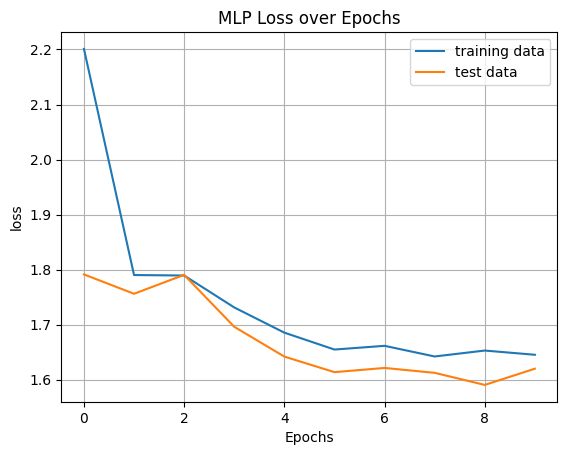

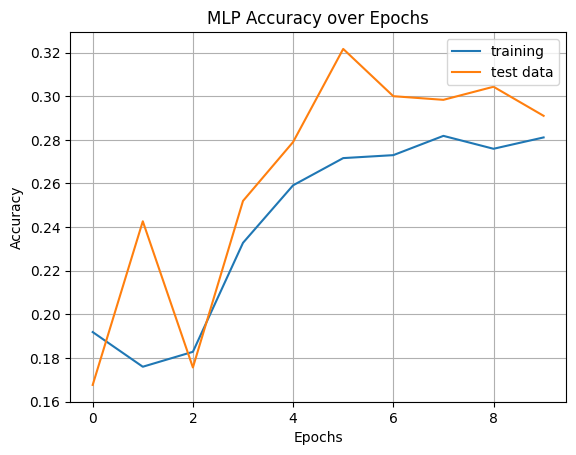

In [19]:
#Plotting the loss
import matplotlib.pyplot as plt

plt.plot(model.history['loss'], label='training data')
plt.plot(model.history['val_loss'], label='test data')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title("MLP Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

plt.plot(model.history['accuracy'], label='training')
plt.plot(model.history['val_accuracy'], label='test data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("MLP Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()